In [1]:
# Core imports
from mycore import ast2station_rotating, ast2station_rotating2, edelbaum

# Main imports
import heyoka as hy
import pykep as pk
import pygmo as pg
import pygmo_plugins_nonfree as ppnf
import pandas as pd

# Usual imports
import time
import numpy as np
import pickle as pkl
import matplotlib as mpl
import matplotlib.pyplot as plt
from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D

from copy import deepcopy

# Jupyter setup
%matplotlib notebook
%load_ext autoreload
%autoreload 2  # Autoreload all modules

In [2]:
# ND Units
TIME = np.sqrt(pk.AU**3/pk.MU_SUN)
L = pk.AU
V = L/TIME

# Load the database of nominal trajectories
The file **nominal_train_value_function_learning.pk** contains can be created by the script parallel_db_creation.py

In [3]:
filename = 'nominal_train_value_function_learning_3'
with open(f"data/{filename}.pk", "rb") as file:
    db = pkl.load(file)
    
# Target orbit definition
r_target = db[0][1]
omega = np.sqrt(pk.MU_SUN / r_target**3)

# Augment the database
We augment the database 

USAGE:

**amplification_factor = 1** for the unaugmented database

**bundle_size=0.0001, amplification_factor = 32** for the unaugmented database  (factor 32 )



In [117]:
# We first construct the udp once (for the taylor integrator)
x0 = db[0][0]
udp = ast2station_rotating2(
    x0 = x0,
    r_target = r_target
)
prob = pg.problem(udp)
prob.c_tol = 1e-4

ta = udp.ta

In [118]:
# Each nominal trajectory will be perturbed by this co-state perturbation
# Use a value of zero to produce(with augmentation factor 1) th results straight from the nominal training set
bundle_size= 0.0001

# Augmentation of the dataset with trajectories from the Backward Propagation
amplification_factor = 32

In [119]:
# We loop into the database to augment the entries

crop_to = int(3000)
tof, eq, osc, tof_edelbaum,pos,vel = [], [], [], [],[],[]
for entry in db[:crop_to]:
    # This line is actually no longer needed but it was when the db contained multiple chromosomes
    # corresponding to local minima
    best_x = sorted(entry[2], key = lambda x: x[-1])[0]
    x0 = entry[0]
    udp.set_x0(x0)
    # Call to fitness updates the state of the ta integrator
    udp.fitness(best_x)
    # We record the final costates
    lambda_f = deepcopy(ta.state[6:])
    x_f = deepcopy(ta.state[:6])
    # ... and time of flight (nd)
    tf = ta.time
    # We process the original db entry
    r,v = x0[:3], x0[3:] # (in SI)
     # We move it to the inertial frame
    v[0] = v[0] - omega * r[1]
    v[1] = v[1] + omega * r[0]
    osculating = pk.ic2par(r,v,pk.MU_SUN)
    equinoctial = pk.ic2eq(r,v,pk.MU_SUN)
    osc.append(osculating)
    eq.append(equinoctial)
    tof.append(tf)
    tof_edelbaum.append(edelbaum(osculating[0], r_target, osculating[2])[1] / TIME)
    pos.append(np.linalg.norm(r))
    vel.append(np.linalg.norm(v))
    
    for i in range(amplification_factor - 1):
        ta.state[:6] = x_f
        # Perturb final costates
        ta.state[6:] = lambda_f + lambda_f * (np.random.rand(6)-0.5) * 2 * bundle_size
        # ... propagate back
        new_tof = tf + np.random.uniform(-0.1,0.1)
        ta.time = 0.
        ta.propagate_until(-new_tof)
        # We move it to the inertial frame
        r = ta.state[:3] * L
        v = ta.state[3:6] * V
        v[0] = v[0] - omega * r[1]
        v[1] = v[1] + omega * r[0]
        osculating = pk.ic2par(r,v,pk.MU_SUN)
        equinoctial = pk.ic2eq(r,v,pk.MU_SUN)
        osc.append(osculating)
        eq.append(equinoctial)
        tof.append(new_tof)
        tof_edelbaum.append(edelbaum(osculating[0], r_target, osculating[2])[1] / TIME)
        pos.append(np.linalg.norm(r))
        vel.append(np.linalg.norm(v))


osc = np.array(osc)
tof_edelbaum = np.array(tof_edelbaum)
tof = np.array(tof)
eq = np.array(eq)
pos = np.array(pos)
vel = np.array(vel)

# We prepare the data for learning

In [120]:
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

In [121]:
# prepare training set
attributes = np.hstack((eq[:,:5], np.sin(eq[:,5]).reshape(-1,1), np.cos(eq[:,5]).reshape(-1,1), tof.reshape(-1,1)))
np.random.shuffle(attributes)
X_train, Y_train = attributes[:,:-1], attributes[:,-1]
min_max_scaler = preprocessing.MinMaxScaler(feature_range=[-1,1])
min_max_scaler.fit(X_train)
X_train_minmax = min_max_scaler.transform(X_train)

In [122]:
# prepare test set
filename = 'nominal_test_value_function_learning_3'
with open(f"data/{filename}.pk", "rb") as file:
    db_test = pkl.load(file)
    
eq_test = []
tof_test = []
for entry in db_test:
    tof_b = sorted(entry[2], key = lambda x: x[-1])[0][-1]
    # We move it to the inertial frame
    r = entry[0][:3] 
    v = entry[0][3:6]
    v[0] = v[0] - omega * r[1]
    v[1] = v[1] + omega * r[0]
    eq_el = pk.ic2eq(r,v,pk.MU_SUN)
    osculating = pk.ic2par(r,v,pk.MU_SUN)
    eq_test.append(eq_el[:5]+(np.sin(eq_el[5]) ,)+(np.cos(eq_el[5]), ))
    tof_test.append(tof_b)
X_test, Y_test = np.array(eq_test), np.array(tof_test)
X_test_minmax = min_max_scaler.transform(X_test)

In [113]:
nn_regr = MLPRegressor(random_state=123, 
                     max_iter=500, 
                     hidden_layer_sizes=(100, 100, 100, 100, 100), 
                     learning_rate = 'adaptive', 
                     batch_size=200, 
                     verbose=True,
                     warm_start = True,
                     activation = 'relu',
                     n_iter_no_change=20,
                     learning_rate_init=0.5*1e-3)

In [96]:
nn_regr.fit(X_train_minmax, Y_train) 

Iteration 1, loss = 21.87953761
Iteration 2, loss = 0.93691479
Iteration 3, loss = 0.54068607
Iteration 4, loss = 0.42129033
Iteration 5, loss = 0.34581903
Iteration 6, loss = 0.30358019
Iteration 7, loss = 0.27057728
Iteration 8, loss = 0.24348115
Iteration 9, loss = 0.21694325
Iteration 10, loss = 0.19635261
Iteration 11, loss = 0.17728119
Iteration 12, loss = 0.16466998
Iteration 13, loss = 0.14947898
Iteration 14, loss = 0.13455288
Iteration 15, loss = 0.12449801
Iteration 16, loss = 0.11515004
Iteration 17, loss = 0.10787016
Iteration 18, loss = 0.10032438
Iteration 19, loss = 0.09474949
Iteration 20, loss = 0.08954068
Iteration 21, loss = 0.08486187
Iteration 22, loss = 0.08162302
Iteration 23, loss = 0.07879957
Iteration 24, loss = 0.07174763
Iteration 25, loss = 0.07106830
Iteration 26, loss = 0.06942353
Iteration 27, loss = 0.06757351
Iteration 28, loss = 0.06213886
Iteration 29, loss = 0.06297955
Iteration 30, loss = 0.06041119
Iteration 31, loss = 0.06105108
Iteration 32, lo

Iteration 253, loss = 0.01833701
Iteration 254, loss = 0.01719165
Iteration 255, loss = 0.01770869
Iteration 256, loss = 0.01947132
Iteration 257, loss = 0.01963970
Iteration 258, loss = 0.01941441
Iteration 259, loss = 0.01690790
Iteration 260, loss = 0.01827634
Iteration 261, loss = 0.01686055
Iteration 262, loss = 0.01778991
Iteration 263, loss = 0.01617687
Iteration 264, loss = 0.01791369
Iteration 265, loss = 0.01919649
Iteration 266, loss = 0.01703736
Iteration 267, loss = 0.01803666
Iteration 268, loss = 0.01662201
Iteration 269, loss = 0.01819537
Iteration 270, loss = 0.01735011
Iteration 271, loss = 0.01775952
Iteration 272, loss = 0.01562068
Iteration 273, loss = 0.01761295
Iteration 274, loss = 0.01749031
Iteration 275, loss = 0.01845928
Iteration 276, loss = 0.01688923
Iteration 277, loss = 0.01629344
Iteration 278, loss = 0.01758541
Iteration 279, loss = 0.01950724
Iteration 280, loss = 0.01611493
Iteration 281, loss = 0.01657151
Iteration 282, loss = 0.01890131
Iteration 

MLPRegressor(batch_size=200, hidden_layer_sizes=(100, 100, 100, 100, 100),
             learning_rate='adaptive', learning_rate_init=0.0005, max_iter=500,
             n_iter_no_change=20, random_state=123, verbose=True,
             warm_start=True)

In [97]:
# This is the evaluation on the actual test part of the original dataset (which is what counts)
Rscore = nn_regr.score(X_test_minmax, Y_test)
predict = nn_regr.predict(X_test_minmax)
predict_t = nn_regr.predict(X_train_minmax)
err_in_days = np.mean(np.abs(predict-Y_test))
err_in_days_t = np.mean(np.abs(predict_t-Y_train))
print("R score: ", Rscore)
print("Error in days: ", err_in_days * TIME * pk.SEC2DAY)
print("Error in days (training): ", err_in_days_t * TIME * pk.SEC2DAY)

R score:  0.9319429473782621
Error in days:  22.63253278025731
Error in days (training):  3.30687652472604


In [98]:
# first run with factor 32 and bundle_size = 0.0001
predict3000_32 = deepcopy(predict)
predict3000_32_t = deepcopy(predict_t)
Y_train3000_32 = deepcopy(Y_train)

# the rune with with augmentation factor 1 and bundle_size = 0.0
#predict3000 = deepcopy(predict)
#predict3000_t = deepcopy(predict_t)
#Y_train3000 = deepcopy(Y_train)


In [105]:
err_in_days = np.mean(np.abs(predict3000-Y_test))
err_in_days_t = np.mean(np.abs(predict3000_t-Y_train3000))
print("R score: ", Rscore)
print("Error in days: ", err_in_days * TIME * pk.SEC2DAY)
print("Error in days (training): ", err_in_days_t * TIME * pk.SEC2DAY)

R score:  0.9319429473782621
Error in days:  34.081810543427366
Error in days (training):  14.333979264755929


#### If you made both runs evaluating the cell above, then you can produce the plot below

<IPython.core.display.Javascript object>


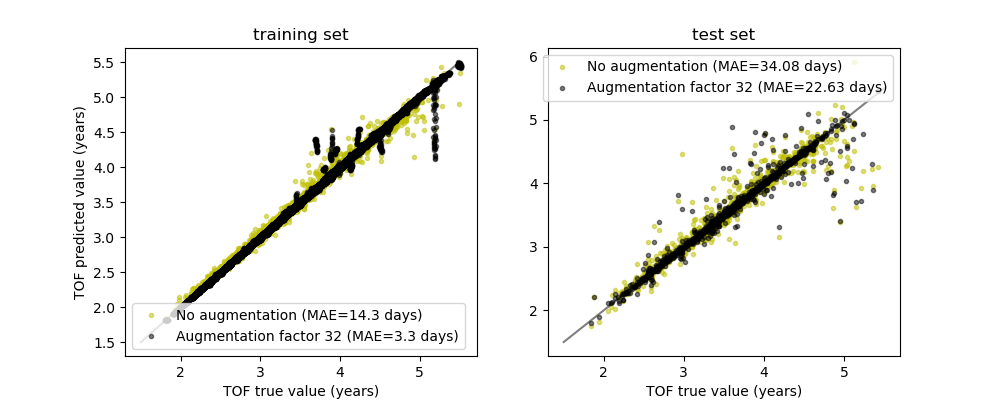

In [107]:
fig,ax = plt.subplots(1,2, figsize = (10,4))

ax[0].plot(Y_train3000* TIME * pk.SEC2DAY/365.25,predict3000_t* TIME * pk.SEC2DAY/365.25, 'y.', alpha=0.5, label="No augmentation (MAE=14.3 days)")
ax[0].plot(Y_train3000_32* TIME * pk.SEC2DAY/365.25,predict3000_32_t* TIME * pk.SEC2DAY/365.25, 'k.', alpha=0.5, label="Augmentation factor 32 (MAE=3.3 days)")
ax[0].plot(np.linspace(1.5,5.5), np.linspace(1.5,5.5),'k', alpha=0.5)

ax[1].plot(Y_test* TIME * pk.SEC2DAY/365.25,predict3000* TIME * pk.SEC2DAY/365.25, 'y.', alpha=0.5, label="No augmentation (MAE=34.08 days)")
ax[1].plot(Y_test* TIME * pk.SEC2DAY/365.25,predict3000_32* TIME * pk.SEC2DAY/365.25, 'k.', alpha=0.5, label="Augmentation factor 32 (MAE=22.63 days)")
ax[1].plot(np.linspace(1.5,5.5), np.linspace(1.5,5.5),'k', alpha=0.5)

ax[0].legend()
ax[1].legend()


ax[0].set_xlabel("TOF true value (years)")
ax[0].set_ylabel("TOF predicted value (years)")
ax[0].set_title("training set")
ax[1].set_xlabel("TOF true value (years)")
ax[1].set_title("test set")


plt.savefig("prediction_error.png", dpi=300)

In [123]:
with open ("training_augmented_32_0.0001.pk", "wb") as file:
    pkl.dump([X_train, Y_train], file)
#with open ("test.pk", "wb") as file:
#    pkl.dump([X_test, Y_test], file)